In [29]:
import warnings
warnings.filterwarnings('ignore')
import pyspark.pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5),'figure.dpi':100})
import seaborn as sns
sns.set_style("white")
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
import itertools
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [30]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [31]:
df_BTC = pd.read_csv("coin_Bitcoin.csv")
df_BTC = df_BTC.tail(500)
df_BTC.shape
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])

22/05/06 21:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/06 21:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/06 21:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [32]:
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


In [33]:
df_ET = pd.read_csv("coin_Ethereum.csv")
df_ET = df_ET.tail(500)
df_ET.shape
df_ET['Date'] = pd.to_datetime(df_ET['Date'])

22/05/06 21:57:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/06 21:57:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/06 21:57:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [34]:
df_ET.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
1660,1661,Ethereum,ETH,2020-02-23 23:59:59,273.754156,261.960509,262.278398,273.754156,1.958600e+10,3.006519e+10
1661,1662,Ethereum,ETH,2020-02-24 23:59:59,275.539515,259.625167,273.705093,265.216417,2.240085e+10,2.913111e+10
1662,1663,Ethereum,ETH,2020-02-25 23:59:59,265.431475,246.858998,265.283387,247.817592,2.187888e+10,2.722340e+10
1663,1664,Ethereum,ETH,2020-02-26 23:59:59,249.649704,221.266555,247.740204,225.680266,2.623562e+10,2.479465e+10
1664,1665,Ethereum,ETH,2020-02-27 23:59:59,237.228921,212.664520,225.687044,226.753395,2.564552e+10,2.491564e+10


<Figure size 700x500 with 0 Axes>

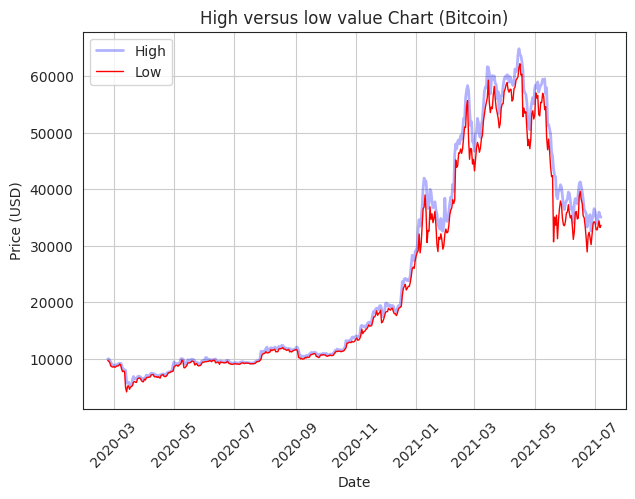

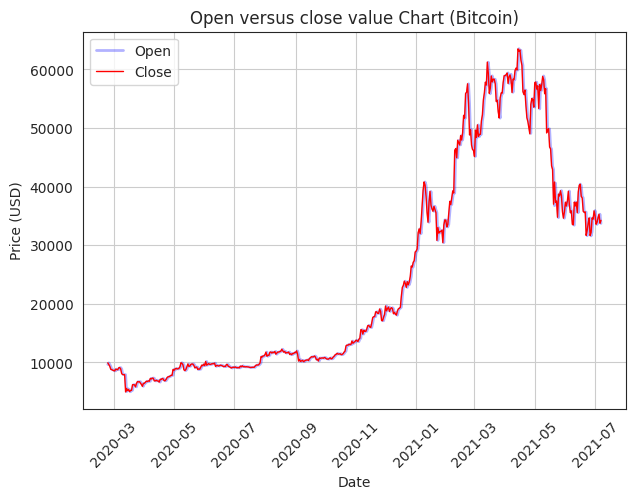

<Figure size 700x500 with 0 Axes>

In [35]:
plt.plot(df_BTC['Date'],df_BTC['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df_BTC['Date'],df_BTC['Low'], "red", linewidth=1,label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df_BTC['Date'],df_BTC['Open'], "blue", linewidth=2, alpha=0.3,label='Open')
plt.plot(df_BTC['Date'],df_BTC['Close'], "red", linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)



<Figure size 700x500 with 0 Axes>

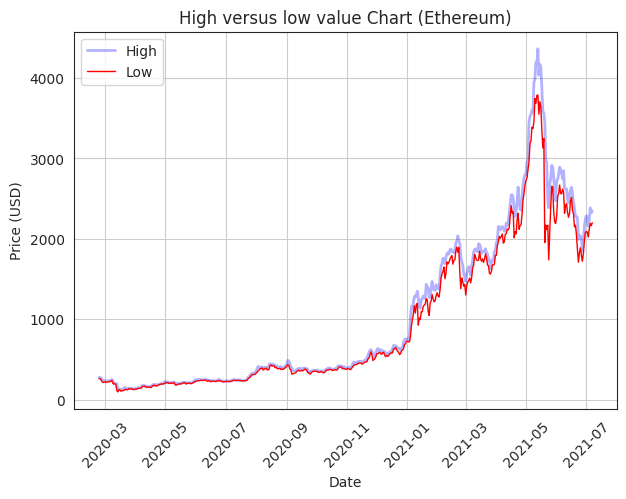

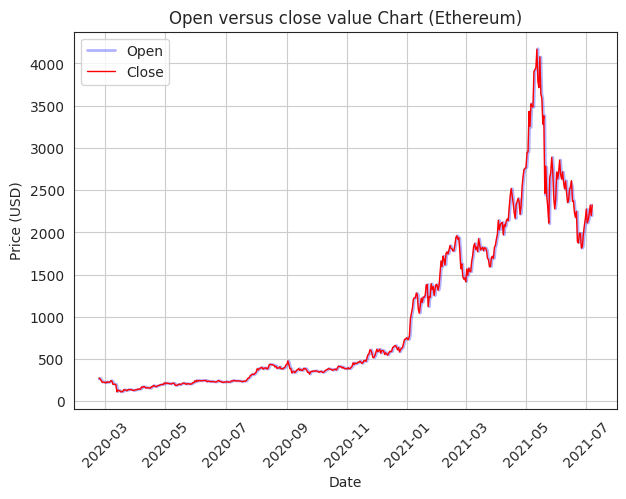

<Figure size 700x500 with 0 Axes>

In [36]:
plt.plot(df_ET['Date'],df_ET['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df_ET['Date'],df_ET['Low'], "red", linewidth=1,label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Ethereum)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df_ET['Date'],df_ET['Open'], "blue", linewidth=2, alpha=0.3,label='Open')
plt.plot(df_ET['Date'],df_ET['Close'], "red", linewidth=1,label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Ethereum)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)

Text(0.5, 1.0, 'Marketcap mean')

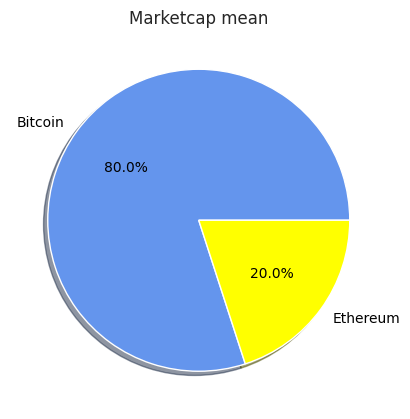

In [37]:
mrkCaps=[df_BTC['Marketcap'].mean(),df_ET['Marketcap'].mean()]
labelList=['Bitcoin','Ethereum']
colors=['cornflowerblue','yellow']
plt.pie(mrkCaps,labels=labelList,colors=colors,autopct='%0.1f%%',shadow=True,textprops={'color':"black"})
plt.title('Marketcap mean')

Text(0.5, 1.0, 'Volume mean')

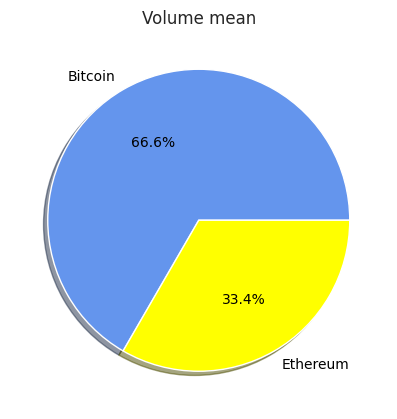

In [38]:
volumes=[df_BTC['Volume'].mean(),df_ET['Volume'].mean()]
labelList=['Bitcoin','Ethereum']
colors=['cornflowerblue','yellow']
plt.pie(volumes,labels=labelList,colors=colors,autopct='%0.1f%%',shadow=True,textprops={'color':"black"})
plt.title('Volume mean')

In [25]:
files_to_use = ["coin_Bitcoin.csv", "coin_Ethereum.csv"]

cols_to_use = []
for ind, file_name in enumerate(files_to_use):
    currency_name = file_name.split("_")[1]
    if ind == 0:
        df = pd.read_csv(file_name, usecols=["Date", "Close"])
        df.columns = ["Date", currency_name]
    else:
        temp_df = pd.read_csv(file_name, usecols=["Date", "Close"])
        temp_df.columns = ["Date", currency_name]
        df = pd.merge(df, temp_df, on="Date")
    cols_to_use.append(currency_name)
df.head()
    

,Date,Bitcoin.csv,Ethereum.csv
0,2015-08-08 23:59:59,260.997009,0.753325
1,2015-08-09 23:59:59,265.083008,0.701897
2,2015-08-10 23:59:59,264.470001,0.708448
3,2015-08-11 23:59:59,270.385986,1.067860
4,2015-08-12 23:59:59,266.376007,1.217440


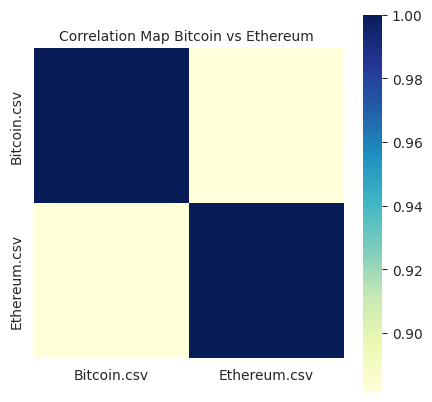

In [26]:
temp_df = df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu")
plt.title("Correlation Map Bitcoin vs Ethereum ", fontsize=10)
plt.show()

Text(0, 0.5, 'Price (USD)')

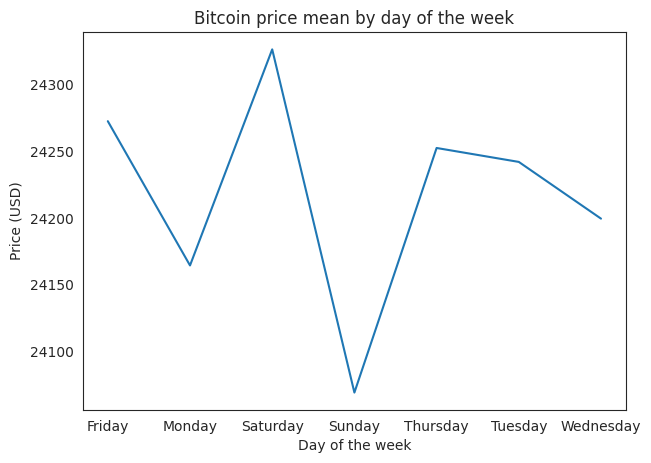

In [27]:
df_BTC['weekday'] = pd.to_datetime(df_BTC['Date']).dt.day_name()
week_data = df_BTC.groupby(['weekday'], as_index=False)['Close'].agg({'mean': 'mean'})
day_of_week = pd.DataFrame(data=week_data)


plt.plot(figsize=(8,4),dpi=80)
plt.title('Bitcoin price mean by day of the week')

my_xticks = np.array(day_of_week.weekday)
plt.xticks(range(len(week_data['mean'])), my_xticks)
plt.plot(range(len(week_data['mean'])), week_data['mean'])
plt.xlabel('Day of the week')
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

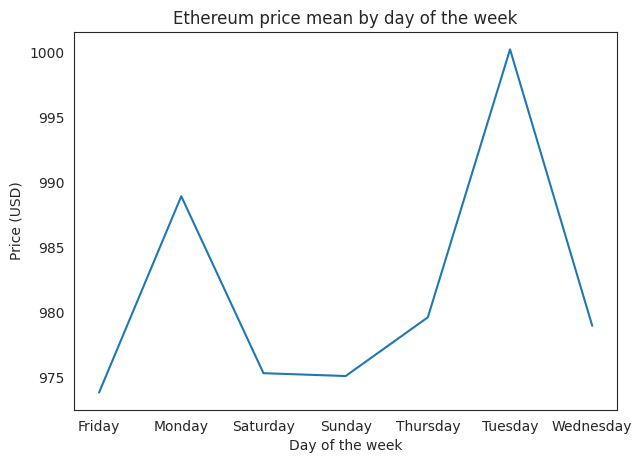

In [28]:
df_ET['weekday'] = pd.to_datetime(df_ET['Date']).dt.day_name()
week_data = df_ET.groupby(['weekday'], as_index=False)['Close'].agg({'mean': 'mean'})
day_of_week = pd.DataFrame(data=week_data)


plt.plot(figsize=(5,10))
plt.title('Ethereum price mean by day of the week')

my_xticks = np.array(day_of_week.weekday)
plt.xticks(range(len(week_data['mean'])), my_xticks)
plt.plot(range(len(week_data['mean'])), week_data['mean'])
plt.xlabel('Day of the week')
plt.ylabel('Price (USD)')

<center><h1>CryptoCurrency Forecasting P2</h1></center>
<center><h2>Hidden Markov Model</h2></center>

## Bitcoin

In [32]:
df_BTC = pd.read_csv("coin_Bitcoin.csv")
df_BTC.shape
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])

In [33]:
start_date = '1/1/2019  11:59:59 PM'
end_date = '7/6/2021  11:59:59 PM'
mask = (df_BTC['Date'] >= start_date) & (df_BTC['Date'] <= end_date)
latestBTC=df_BTC.loc[mask]

In [34]:
#Hacemos dos subset, uno con solo la data de 2019-202o para train y otra de solo 2021 para testing
start_date = '1/1/2019  11:59:59 PM'
end_date = '1/1/2021  11:59:59 PM'
mask = (latestBTC['Date'] >= start_date) & (latestBTC['Date'] < end_date)
df=latestBTC.loc[mask]
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2073,2074,Bitcoin,BTC,2019-01-01 23:59:59,3850.913765,3707.231303,3746.713387,3843.519967,4.324201e+09,6.709863e+10
2074,2075,Bitcoin,BTC,2019-01-02 23:59:59,3947.981273,3817.409496,3849.216409,3943.409337,5.244857e+09,6.884986e+10
2075,2076,Bitcoin,BTC,2019-01-03 23:59:59,3935.685131,3826.222871,3931.048638,3836.741319,4.530215e+09,6.699492e+10
2076,2077,Bitcoin,BTC,2019-01-04 23:59:59,3865.934532,3783.853665,3832.039968,3857.717619,4.847965e+09,6.736833e+10
2077,2078,Bitcoin,BTC,2019-01-05 23:59:59,3904.903096,3836.900126,3851.973965,3845.194460,5.137610e+09,6.715757e+10


In [35]:
start_date = '1/1/2021  11:59:59 PM'
end_date = '31/12/2021  11:59:59 PM'
mask = (df_BTC['Date'] >= start_date) & (df_BTC['Date'] <= end_date)
test=df_BTC.loc[mask]
test.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2804,2805,Bitcoin,BTC,2021-01-01 23:59:59,29600.626950,28803.585014,28994.008916,29374.151889,4.073030e+10,5.460016e+11
2805,2806,Bitcoin,BTC,2021-01-02 23:59:59,33155.118819,29091.181191,29376.455834,32127.267939,6.786542e+10,5.972059e+11
2806,2807,Bitcoin,BTC,2021-01-03 23:59:59,34608.556738,32052.317076,32129.407356,32782.024466,7.866524e+10,6.094092e+11
2807,2808,Bitcoin,BTC,2021-01-04 23:59:59,33440.218569,28722.755271,32810.947644,31971.913522,8.116348e+10,5.943840e+11
2808,2809,Bitcoin,BTC,2021-01-05 23:59:59,34437.590592,30221.186739,31977.041132,33992.429344,6.754732e+10,6.319800e+11


<Figure size 700x500 with 0 Axes>

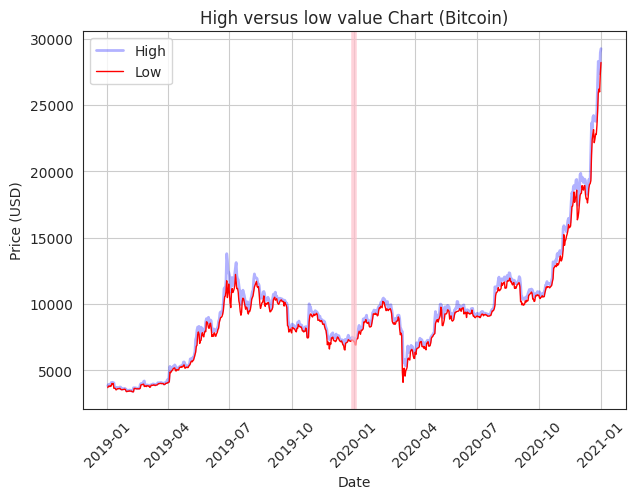

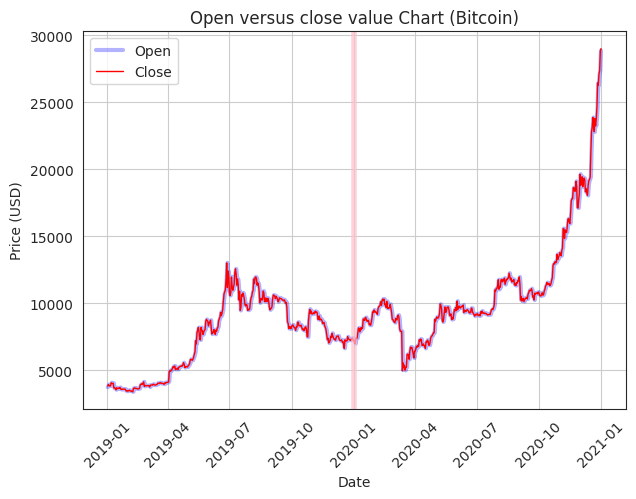

<Figure size 700x500 with 0 Axes>

In [36]:
#Ploteamos solo la data de 2019-2020 para revisar tendencia y efectos por COVID-19
plt.plot(df['Date'],df['High'], "blue", linewidth=2, alpha=0.3,label='High')
plt.plot(df['Date'],df['Low'], "red", linewidth=1,label='Low')
plt.axvline(pd.Timestamp('2020-01-01 23:59:59'),color='pink',alpha=0.7, linewidth=4)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('High versus low value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(200)
plt.plot(df['Date'],df['Open'], "blue", linewidth=3, alpha=0.3,label='Open')
plt.plot(df['Date'],df['Close'], "red", linewidth=1,label='Close')
plt.axvline(pd.Timestamp('2020-01-01 23:59:59'),color='pink',alpha=0.7, linewidth=4)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Open versus close value Chart (Bitcoin)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.figure(300)

In [37]:
def compute_all_possible_outcomes(n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):
    frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
    frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
    frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
    possible_outcomes = np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
    return possible_outcomes

In [38]:
def get_most_probable_outcome(possible_outcomes, hmm, test_data, n_latency_days, day_index):
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_end_index: previous_data_start_index]
    previous_data_features = extract_features(previous_data)
    outcome_score = []
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((previous_data_features, possible_outcome))
        outcome_score.append(hmm.score(total_data))
    
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]
    return most_probable_outcome

In [39]:
def predict_close_price(possible_outcomes, hmm, test_data, n_latency_days, day_index):
    open_price = test_data.iloc[day_index]['Open']
    predicted_frac_change = get_most_probable_outcome(possible_outcomes, hmm, test_data, n_latency_days, day_index)
    return open_price * (1 + predicted_frac_change)

def predict_close_prices_for_days(company,possible_outcomes, hmm, test_data, n_latency_days, days, with_plot=False):
  predicted_close_prices = []
  #print("Predict_close_prices_for_days|test_data",test_data)
  for day_index in tqdm(range(days)):
    predicted_close_prices.append(predict_close_price(possible_outcomes, hmm, test_data, n_latency_days, day_index))
  if with_plot:
    plot_actual_vs_predicted(company,predicted_close_prices,test_data,days)
  return predicted_close_prices

In [40]:
def plot_actual_vs_predicted(company,predicted, test_data, d):
    predicted_close_prices = pd.DataFrame(predicted)
    test_d = test_data[0: d]
    days = np.array(test_d['Date'], dtype="datetime64[ms]")
    actual_close_prices = test_d['Close']
    df = pd.DataFrame(actual_close_prices)
    df["frac_change"] = predicted_close_prices[0].values
    df["high_range"] = predicted_close_prices[1].values
    df["low_range"] = predicted_close_prices[2].values
    diff_0 = abs( (df["Close"] - df["frac_change"]).sum() )
    diff_1 = abs( (df["Close"] - df["high_range"]).sum() )
    diff_2 = abs( (df["Close"] - df["low_range"]).sum() )
    if(diff_0 < diff_1):
        label ="frac_change"
        pred = df["frac_change"]
        diff = diff_0
    else:
        label ="high_range"
        pred = df["high_range"]
        diff = diff_1
    if(diff_2 < diff):
        label ="low_range"
        pred = df["low_range"]
        diff = diff_2
    fig = plt.figure()
    
    print(diff_0, diff_1, diff_2)
    axes = fig.add_subplot(111)
    axes.plot(days, actual_close_prices, 'bo-', label="actual")
    axes.plot(days, pred, 'r+-', label="predicted")
    axes.set_title('%s - %s Diff:%f' % (company,label,diff))
    fig.autofmt_xdate()
    plt.legend()
    plt.grid()
    plt.show()

In [41]:
def hmm_prediction(currency, n_hidden_states = 5, test_size = 0.20, n_latency_days = 10, n_steps_frac_change=20, n_steps_frac_high=10, n_steps_frac_low=10, days= 20 ):
  # separar train & test
  train_data, test_data = df, test
  print("train records:",len(train_data)," test records:",len(test_data))
  #print(test_data.head())
  
  # modelo
  hmm = GaussianHMM(n_components=n_hidden_states)
  feature_vector = extract_features(train_data)
  fit = hmm.fit(feature_vector)
  #
  all_possible_outcomes = compute_all_possible_outcomes(n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
  predicted = predict_close_prices_for_days(currency, all_possible_outcomes, hmm, test_data.tail(days), n_latency_days,days, with_plot=True)
  return predicted

In [42]:
def extract_features(data):
    open_price = data['Open']
    close_price = data['Close']
    high_price = data['High']
    low_price = data['Low']
    # Compute the fraction change in close, high and low prices
    # which would be used a feature
    df = pd.DataFrame()
    df["frac_change"]= (close_price - open_price) / open_price
    df["frac_high"] = (high_price - open_price) / open_price
    df["frac_low"] = (open_price - low_price) / open_price
    return df

train records: 731  test records: 187


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


7103.257929821608 9513.531729024711 1880.998031548217


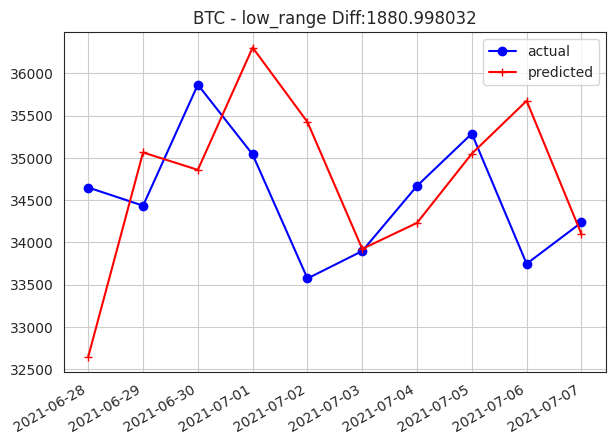

[array([33137.19487453, 33363.77398478, 32646.27346898]),
 array([35591.73070158, 35835.09296279, 35064.44580229]),
 array([35382.81126761, 35624.74501987, 34858.62147106]),
 array([36853.34563451, 37105.33432261, 36307.37014363]),
 array([35957.98225733, 36203.84880268, 35425.27140907]),
 array([34432.48439259, 34667.92018331, 33922.3735127 ]),
 array([34745.32718685, 34982.9020736 , 34230.5815989 ]),
 array([35577.81657308, 35821.08369495, 35050.73780904]),
 array([36212.87980981, 36460.48924441, 35676.39270152]),
 array([34610.97043555, 34847.62664366, 34098.21531798])]

In [43]:
#Generamos el modelo para predecir
hmm_prediction('BTC', n_hidden_states=5, n_latency_days=5, days=10)